<a href="https://colab.research.google.com/github/werew/deep-trading/blob/main/cnn_cont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from collections import defaultdict
import json
from sys import float_info

%pip install wandb
import wandb

from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

project_name = 'cnn_cont'
project_dir = '/content/drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cuda device


In [ ]:
%pip install -U git+https://github.com/twopirllc/pandas-ta
import pandas_ta as ta

  Cloning https://github.com/twopirllc/pandas-ta to /tmp/pip-req-build-8_zza_f_
  Running command git clone -q https://github.com/twopirllc/pandas-ta /tmp/pip-req-build-8_zza_f_


# Common

In [ ]:
def random_seed(seed):
  torch.manual_seed(seed)
  random.seed(0)
  np.random.seed(0)

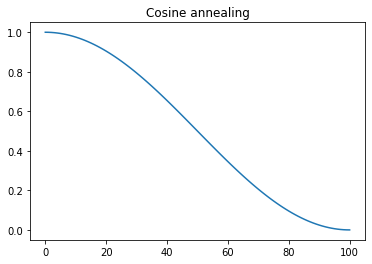

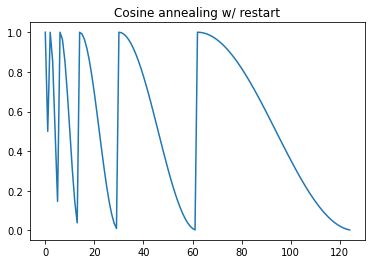

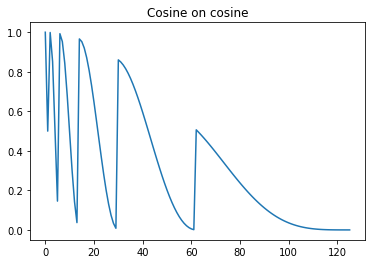

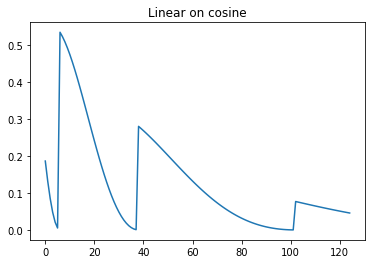

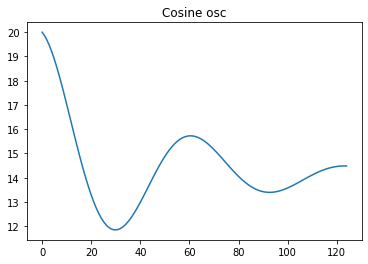

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
def cosine_annealing(start, T_max, eta_min=0, last_epoch=0):
  n_min, n_max = eta_min, start
  T_cur = last_epoch
  while T_cur <= T_max:
    yield ((n_min + (n_max - n_min)) * (1 + math.cos(math.pi * T_cur / T_max))) / 2
    T_cur += 1

plt.title('Cosine annealing')
plt.plot(np.array(list(cosine_annealing(1, 100))))
plt.show()

def cosine_annealing_warm_restars(start, T_0, T_mult=1, eta_min=0, last_epoch=0):
  n_min, n_max = eta_min, start

  if T_mult == 1:
    T_cur = last_epoch % T_0
    T_i = T_0
  else:
    n = int(math.log((last_epoch / T_0 * (T_mult - 1) + 1), T_mult))
    T_cur = last_epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
    T_i = T_0 * T_mult ** n

  while True:
    yield ((n_min + (n_max - n_min)) * (1 + math.cos(math.pi * T_cur / T_i))) / 2

    T_cur += 1
    if T_cur >= T_i:
      T_cur -= T_i
      T_i *= T_mult

    last_epoch += 1

plt.title('Cosine annealing w/ restart')
g = cosine_annealing_warm_restars(1, 1, 2, last_epoch=1)
plt.plot([next(g) for i in range(125)])
plt.show()

def cosine_on_cosine(start, periods, T_0, T_mult=1, eta_min=0, last_epoch=0):
  T_max = int(T_0 * (1 - T_mult ** (periods + 1)) / (1 - T_mult))
  c = cosine_annealing(1, T_max=T_max, last_epoch=last_epoch)
  wr = cosine_annealing_warm_restars(start, T_0, T_mult=T_mult, eta_min=eta_min, last_epoch=last_epoch)
  for _ in range(T_max - last_epoch):
    cy = next(c)
    yield cy * next(wr)


plt.title("Cosine on cosine")
cc = cosine_on_cosine(1, 6, 1, 2, last_epoch=1)
plt.plot(list(cc))
plt.show()

def linear_on_cosine(start, coef, T_0, T_mult=1, eta_min=0, last_epoch=0):
  wr = cosine_annealing_warm_restars(start, T_0, T_mult=T_mult, eta_min=eta_min, last_epoch=last_epoch)
  while True:
    yield next(wr) * (coef ** last_epoch)
    last_epoch += 1


plt.title("Linear on cosine")
lc = linear_on_cosine(1, 0.98, 1, 2, last_epoch=25)
plt.plot([ next(lc) for _ in range(125)])
plt.show()


def cosine_osc(target, upper, lower, last_epoch=0, a=0.98, osc=0.2):
  while True:
    cos = math.cos(last_epoch * osc)
    k = (a ** last_epoch) * cos / 2 + target

    if cos > 0:
      yield k + (a ** last_epoch)*(cos*upper - cos*target)
    else:
      yield k + (a ** last_epoch)*(cos*lower + cos*target)
    last_epoch += 1


def cosine_osc(target, upper, lower, last_epoch=0, annealing_coef=0.98, freq_coef=0.1):
  while True:
    c = math.cos(last_epoch * freq_coef)
    a = (annealing_coef ** last_epoch)

    u = target + (upper - target)*a
    l = target - (target - lower)*a
    k = (a * c * (upper - lower) + u + l) / 2
    yield k
    last_epoch += 1

plt.title("Cosine osc")
g = cosine_osc(14, 20, 10, last_epoch=0)
plt.plot([ next(g) for _ in range(125)])
plt.show()

# Dataset setup


In [ ]:
def load_dataset(pair):
    pair = pair.replace('/','_')
    ds = pd.read_csv(os.path.join(project_dir+"/datasets",f'{pair}_dataset.gz'))
    with open(os.path.join(project_dir+"/datasets",f'{pair}_dataset_config.json'), 'r') as fd:
        config = json.load(fd)
    return ds, config

ds = None
configs = {}
for pair in ['BTC/BUSD', 'ETH/BUSD', 'BTC/USDT', 'ETH/USDT']:
  df, config = load_dataset(pair)

  # Add suffix to columns
  df.columns = df.columns.map(lambda x : x+f'_{pair}' if x != 'date' else x)
  if ds is None:
    ds = df
  else:
    ds = pd.merge(ds, df, on='date', copy=False)

  configs[pair] = config

In [ ]:
# Filter rows w/ NaNs
ds = ds[ds.isnull().sum(axis=1) == 0]

In [ ]:
ds.loc[:,['max_return_0.5_BTC/BUSD']] = ds['max_return_BTC/BUSD'] * 50

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan


In [ ]:
from torch.utils.data import IterableDataset

class MultiBucketsDataset(IterableDataset):
  def __init__(self, ds, x_cols, y_cols, category, seq_len, category_col='category'):
    self.ds = ds
    self.x_cols = x_cols
    self.y_cols = y_cols
    self.seq_len = seq_len

    # Create groups
    buckets = (ds[category_col] != ds[category_col].shift()).cumsum()
    buckets.name = 'bucket'
    self.groups = ds[ds[category_col] == category].groupby(buckets)

    self._groups_names = sorted(self.groups.indices.keys())

  def nb_groups(self):
    return len(self._groups_names)

  def _iter_group(self, g):
    x = torch.tensor(g[self.x_cols].swapaxes(0,1, copy=False).values).to(device)
    y = torch.tensor(g[self.y_cols].swapaxes(0,1, copy=False).values).to(device)

    for i in range(x.shape[1]-self.seq_len+1):
      yield x[:,i:i+self.seq_len], y[:,i:i+self.seq_len]

  def get_group(self, n):
    return self.groups.get_group(self._groups_names[n])

  def iter_group(self, n):
    g = self.get_group(n)
    return self._iter_group(g)

  def __len__(self):
    return self.groups.size().sum()

  def __iter__(self):
    for k,g in self.groups:
      yield from self._iter_group(g)

# Training setup

In [ ]:
class Model(nn.Module):

 def __init__(self, input_shape, dims=[3, 64, 32]):
   super(Model, self).__init__()
   self.dims = dims
   self.input_shape = input_shape
   self.dropout_00 = nn.Dropout(p=0.2)

   self.cnn_0 = nn.Conv1d(in_channels=input_shape[0], out_channels=dims[0], kernel_size=5, padding='same')
   self.bn_0 = nn.BatchNorm1d(num_features=dims[0])
   self.dropout_0 = nn.Dropout(p=0.5)
   self.lrelu_0 = nn.LeakyReLU()

   #self.cnn_1 = nn.Conv1d(in_channels=input_shape[0], out_channels=dims[1], kernel_size=5, padding='same')
   #self.cnn_1 = nn.Conv1d(in_channels=dims[0], out_channels=dims[1], kernel_size=5, padding='same')
   #self.bn_1 = nn.BatchNorm1d(num_features=dims[1])
   #self.dropout_1 = nn.Dropout(p=0.5)
   #self.lrelu_1 = nn.LeakyReLU()

   #self.cnn_2 = nn.Conv1d(in_channels=dims[1], out_channels=dims[2], kernel_size=3, padding='same')
   #self.bn_2 = nn.BatchNorm1d(num_features=dims[2])
   #self.dropout_2 = nn.Dropout(p=0.5)
   #self.lrelu_2 = nn.LeakyReLU()

   self.avgp_3 = nn.AvgPool1d(8)
   self.flatten_3 = nn.Flatten()
   self.linear_3 = nn.Linear(in_features=int(self.input_shape[1] / 8 * dims[0]), out_features=1)

 def forward(self, x):
   x = x.to(torch.float32)
   x = self.dropout_00(x)

   x = self.cnn_0(x)
   x = self.bn_0(x)
   x = self.dropout_0(x)
   x = self.lrelu_0(x)

   #x = self.cnn_1(x)
   #x = self.bn_1(x)
   #x = self.dropout_1(x)
   #x = self.lrelu_1(x)

   #x = self.cnn_2(x)
   #x = self.bn_2(x)
   #x = self.dropout_2(x)
   #x = self.lrelu_2(x)

   x = self.avgp_3(x)
   x = self.flatten_3(x)
   x = self.linear_3(x)

   return x

def load_model(version, input_shape):
  model = Model(input_shape)
  model_path = f'{project_dir}/{project_name}_model_{version}.pt'
  model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
  return model

def save_model(model, version):
  model_path = f'{project_dir}/{project_name}_model_{version}.pt'
  torch.save(model.state_dict(), model_path)

In [ ]:
# def get_trading_results(params, preds, prices):
#   t = params['hyperparams']['threshold']
#   position = None
#   invested = []
#   returns = []
#   pct_change = lambda a,b: (b-a) / a

#   for i, (price, pred) in enumerate(zip(prices.view(-1), preds)):
#     price, pred = price.item(), pred.item()
#     invested.append(position is not None)

#     if pred > t:
#       if position is None:
#         position = {'i':i, 'price':price} # Buy
#       else:
#         position['i'] = i # Update for timeout
#       continue

#     if position is None:
#       continue

#     roi = pct_change(position['price'], price)
#     if roi >= 0.2 or roi <= -0.1 or i > position['i'] + RETURNS_WINDOW*2:
#       position = None
#       returns.append(roi)

#   returns = torch.tensor(returns)
#   return {
#       'number_returns': len(returns),
#       'total_returns': returns.sum().item(),
#       'std_returns': returns.std().item(),
#       'mean_returns': returns.mean().item(),
#       'median_returns': returns.median().item(),
#       'invested': torch.tensor(invested),
#   }

def get_metrics(pred, y, threshold):
    t = threshold
    return {
      'tp': ((pred > t) & (y > t )).sum().item(),
      'fp': ((pred > t) & (y <= t)).sum().item(),
      'tn': ((pred <= t) & (y <= t)).sum().item(),
      'fn': ((pred <= t) & (y > t)).sum().item(),
    }

def get_precision_recall(res):
  e = float_info.epsilon
  return {
    f'precision': (
        res['tp'] / (res['tp'] + res['fp'] + e)
    ),
    f'recall': (
        res['tp'] / (res['tp'] + res['fn'] + e)
    ),
  }

def _loop(params, dataloader, backprop=False, return_raw_preds=False):
    num_batches = len(dataloader)
    res = defaultdict(int)

    # Used if return_raw_preds is True
    preds = {'y_true': [], 'y_score':[]}

    for batch, (x, y) in enumerate(dataloader):

        y_orig = y[:,:,-1:].view(-1,1)
        y_orig = y_orig.to(torch.float32)
        y = y_orig

        # Compute prediction and loss
        pred = params['model'](x)
        loss = params['loss_fn'](pred, y)

        # Return raw predictions
        if return_raw_preds:
          preds['y_true'].append(y)
          preds['y_score'].append(pred)

        # Backpropagation
        if backprop:
          params['optimizer'].zero_grad()
          loss.backward()
          params['optimizer'].step()

        # Add up loss
        res['loss'] += loss.item()

        # Get metrics
        threshold = params['hyperparams']['threshold']
        for k,v in get_metrics(pred=pred, y=y_orig, threshold=threshold).items():
          res[k] += v

        if batch % 500 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{num_batches:>5d}]")

    res['loss'] /= num_batches
    res.update(get_precision_recall(res))

    if return_raw_preds:
      preds['y_true'] = torch.cat(preds['y_true'])
      preds['y_score'] = torch.cat(preds['y_score'])
      return res, preds

    return res

def train_loop(params, dataloader):
    params['model'].train()
    return _loop(params, dataloader, backprop=True, return_raw_preds=False)

def test_loop(params, dataset):
    # Dataloader only needed to avoid loading the data all at once
    dataloader = DataLoader(dataset, batch_size=params['hyperparams']['batch_size'], shuffle=False)
    params['model'].eval()

    with torch.no_grad():
      res, preds = _loop(params, dataloader, backprop=False, return_raw_preds=True)

      # Add AUC to res
      fpr, tpr, _ = metrics.roc_curve(
        (preds['y_true'] > params['hyperparams']['threshold']).int().cpu(),
        preds['y_score'].cpu(),
        pos_label=1,
      )
      res['auc'] = metrics.auc(fpr, tpr)

      return res, preds


In [ ]:
# We start at epoch zero
epoch = 0

# Init W&B run
wandb_run = wandb.init(project=project_name, name="multi_v1_96_cnn_3_7_avg_8_dense")

# Load model
INPUT_SHAPE = (sum([len(c['normalized']) for c in configs.values()]), 96)
#model = load_model('deep-bee-1', input_shape=INPUT_SHAPE)
model = Model(input_shape=INPUT_SHAPE)
model.to(device)

batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,64
epoch,20
learning_rate,0.001
threshold,0.5


Model(
  (dropout_00): Dropout(p=0.2, inplace=False)
  (cnn_0): Conv1d(160, 3, kernel_size=(5,), stride=(1,), padding=same)
  (bn_0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_0): Dropout(p=0.5, inplace=False)
  (lrelu_0): LeakyReLU(negative_slope=0.01)
  (avgp_3): AvgPool1d(kernel_size=(8,), stride=(8,), padding=(0,))
  (flatten_3): Flatten(start_dim=1, end_dim=-1)
  (linear_3): Linear(in_features=36, out_features=1, bias=True)
)

In [ ]:
# Hyperparams
hyperparams = {
  'learning_rate': 0.001,
  'batch_size': 64,
  'threshold': 0.5,
}

params = {
  'hyperparams': hyperparams,
  'loss_fn': nn.MSELoss(),
  'optimizer': torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate']),
  'model': model,
}

X_COLS = [ col+f'_{pair}' for pair,c in configs.items() for col in c['normalized']]
Y_COLS = ['max_return_0.5_BTC/BUSD']
SEQ_LEN = params["model"].input_shape[1]


# Training

In [ ]:
#params['hyperparams']['learning_rate'] = 0.0001
params['hyperparams']['learning_rate'] = 1.

In [ ]:
training_data = MultiBucketsDataset(ds, X_COLS, Y_COLS,'train', SEQ_LEN, category_col='category_BTC/BUSD')
train_dataloader = DataLoader(training_data, batch_size=hyperparams['batch_size'], shuffle=False)

testing_data = MultiBucketsDataset(ds, X_COLS, Y_COLS, 'dev', SEQ_LEN, category_col='category_BTC/BUSD')

# Create a random selection of rows for wandb roc plot (otherwise wandb will
# only plot the first MAX_ROWS of the first category)
# We need to pass thorugh a temporary dataloader to estimate the number of y rows
tmp_dataloader = DataLoader(testing_data, batch_size=params['hyperparams']['batch_size'], shuffle=False)
high = sum((y.shape[0] for _,y in tmp_dataloader))
del tmp_dataloader

random_seed(42)
TEST_SELECTION = torch.randint(0, high, (wandb.Table.MAX_ROWS // 2,))

In [ ]:
# Training
for _ in range(20):
  epoch += 1
  print(f"Epoch {epoch}\n-------------------------------")

  # Train
  train_res = train_loop(params, train_dataloader)

  # Test
  test_res, test_preds = test_loop(params, testing_data)

  # Show some data
  print(
      f"\nTrain loss: {train_res['loss']}\n"
      f"Test loss: {test_res['loss']}\n"
      f"Test precision: {test_res['precision']}\n"
      f"Test recall: {test_res['recall']}\n"
      f"Test AUC: {test_res['auc']}\n"
  )

  # Plot ROC curve
  y_true = (test_preds['y_true'] > params['hyperparams']['threshold']).int().cpu()

  y_score = torch.stack([
      (test_preds['y_score'] * -1 + 1).flatten(), # scores for category 0
      (test_preds['y_score']).flatten(), # scores for category 1
  ], dim=1).cpu()

  roc_curve = wandb.plot.roc_curve(
    torch.index_select(y_true, 0, TEST_SELECTION),
    torch.index_select(y_score, 0 , TEST_SELECTION),
  )

  # Log results
  wandb_run.log({
    'epoch': epoch,
    'train': train_res,
    'test': test_res,
    'roc': roc_curve,
    **hyperparams,
  })

Epoch 1
-------------------------------
loss: 0.048519  [    0/14400]
loss: 0.012628  [  500/14400]
loss: 0.048786  [ 1000/14400]
loss: 0.145351  [ 1500/14400]
loss: 0.019517  [ 2000/14400]
loss: 0.477319  [ 2500/14400]
loss: 0.048050  [ 3000/14400]
loss: 0.028118  [ 3500/14400]
loss: 0.036944  [ 4000/14400]
loss: 0.010603  [ 4500/14400]
loss: 0.017861  [ 5000/14400]
loss: 0.158271  [ 5500/14400]
loss: 0.001015  [ 6000/14400]
loss: 0.048911  [ 6500/14400]
loss: 0.075930  [ 7000/14400]
loss: 0.171499  [ 7500/14400]
loss: 0.375210  [ 8000/14400]
loss: 0.030261  [ 8500/14400]
loss: 0.055737  [ 9000/14400]
loss: 0.048646  [ 9500/14400]
loss: 0.211859  [10000/14400]
loss: 0.079865  [10500/14400]
loss: 0.110561  [11000/14400]
loss: 1.451812  [11500/14400]
loss: 0.752009  [12000/14400]
loss: 0.454993  [12500/14400]
loss: 0.046509  [13000/14400]
loss: 0.021836  [13500/14400]
loss: 0.019985  [14000/14400]
loss: 3.363837  [    0/ 1675]
loss: 5.618943  [  500/ 1675]
loss: 1.182069  [ 1000/ 1675]


# Testing

In [ ]:
def get_preds(dataset):
  params['model'].eval()
  with torch.no_grad():
    preds = {
        'pred_raw': [],
        'pred': [],
    }
    for i in range(dataset.nb_groups()):
      tmp = [torch.nan]*(SEQ_LEN-1)
      for x, y in dataset.iter_group(i):
        x = x.view(1, -1, SEQ_LEN)
        tmp.append(params['model'](x))

      preds['pred_raw'].append(torch.tensor(tmp))
      preds['pred'].append(torch.sigmoid(preds['pred_raw'][-1]))

    return preds

In [ ]:
params['hyperparams']['threshold'] = 0.5
dev_data = MultiBucketsDataset(ds, X_COLS, Y_COLS,'dev', SEQ_LEN)
dev_res = test_loop(params, dev_data)
dev_res

loss: 0.006735  [    0/  681]
loss: 0.012337  [  500/  681]


defaultdict(int,
            {'fn': 9737,
             'fp': 40,
             'loss': 0.12813836656542968,
             'precision': 0.6428571428571422,
             'recall': 0.007340197777551229,
             'tn': 31129,
             'tp': 72})

In [ ]:
dev_pred = get_preds(dev_data)
#dev_trading = get_trading_results(params, dev_pred['pred'], dev_data.raw[model.size:])
#dev_trading


In [ ]:
test_data = MultiBucketsDataset(ds, X_COLS, Y_COLS,'test', SEQ_LEN)
test_res = test_loop(params, test_data)
print(test_res)

loss: 0.161619  [    0/  737]
loss: 2.250417  [  500/  737]
defaultdict(<class 'int'>, {'loss': 0.41552072872844964, 'tp': 802, 'fp': 1265, 'tn': 30528, 'fn': 11966, 'precision': 0.38800193517174647, 'recall': 0.06281328320802006})


In [ ]:
save_model(model, wandb_run.name)

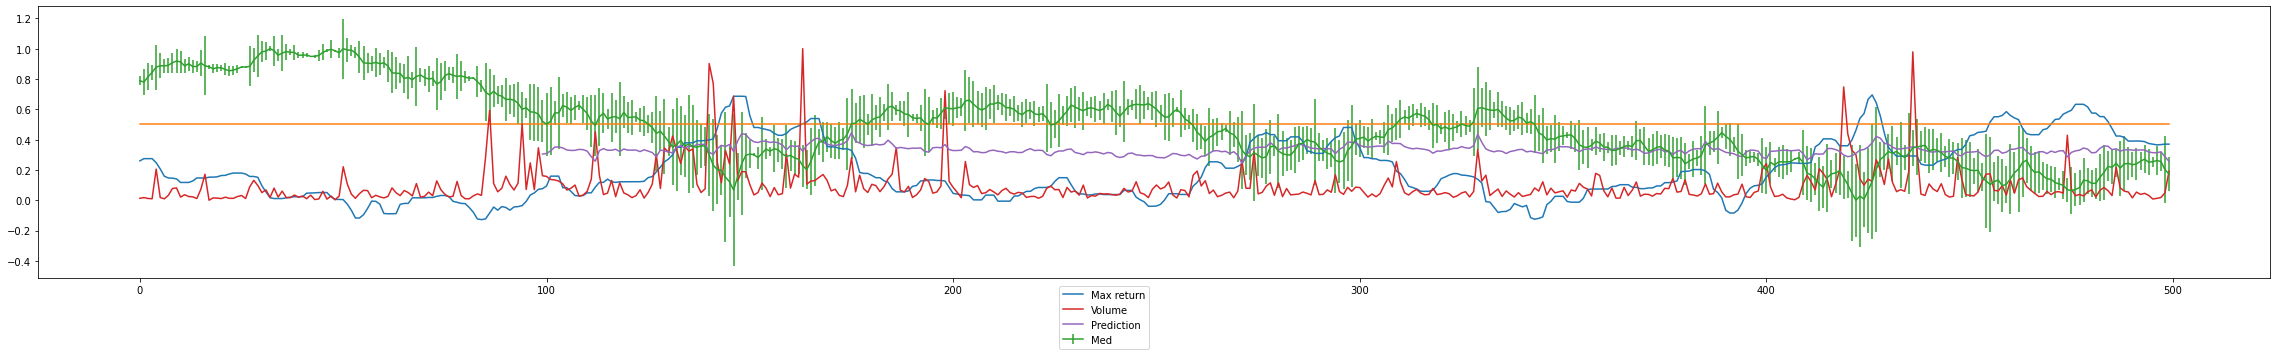

In [ ]:
plt.rcParams['figure.figsize'] = [40, 5]

# View
g = 19
w = 500
s = w*0
e = s+w

def scale(s):
  return (s - s.min()) / (s.max() - s.min())

# tmp = ds[ds['category'] == 'dev'].iloc[s:e]
tmp = dev_data.get_group(g).iloc[s:e]
plt.plot((tmp['max_return']*50).values, label='Max return')
plt.plot([0.5]*w)
spread = scale(tmp['high'] - tmp['low']) / 2
plt.errorbar(list(range(w)), scale(tmp['med']), yerr=spread, label="Med")
plt.plot(scale(tmp['volume'].values), label="Volume")
plt.plot(dev_pred['pred_raw'][g][s:e], label="Prediction")
plt.legend(bbox_to_anchor=(0.5, -0.01))
plt.show()

In [ ]:
t_pred = 0.5
t_y = 0.01
tp = 0
fp = 0
res = defaultdict(int)
for i in range(dev_data.nb_groups()):
  pred_raw = dev_pred['pred'][i][SEQ_LEN-1:]
  y_raw = dev_data.get_group(i)['max_return'].iloc[SEQ_LEN-1:]
  y_raw = torch.tensor(y_raw.values).cpu()

  y = dev_data.get_group(i)['max_return_labels'].iloc[SEQ_LEN-1:]
  y = torch.tensor(y.values).cpu()
  pred = pred_raw > t_pred

  for k,v in get_metrics(pred=pred, y=y, threshold=t_pred).items():
    res[k] += v

print(res)
print(get_precision_recall(res))


defaultdict(<class 'int'>, {'tp': 839, 'fp': 1837, 'tn': 29332, 'fn': 8970})
{'precision': 0.31352765321375187, 'recall': 0.08553369354674278}
